# IMPORT LIBRARIES

In [21]:
# from rdflib import Graph, URIRef, Literal, RDF
import open3d as o3d
import os
from pathlib import Path
import numpy as np
import laspy
import cv2
import copy
import ezdxf
import matplotlib.pyplot as plt

#IMPORT MODULES
from context import geomapi 
from geomapi.nodes import *
import geomapi.utils as ut
from geomapi.utils import geometryutils as gmu
import geomapi.tools as tl
from geomapi.utils import imageutils as iu
from geomapi.tools import progresstools as pt
# my functions
# import functions as fun
from geomapi.tools import validationtools as vt

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

# INPUTS

In [4]:
folder='D:/Data/TUCRAIL/'
xmlPath = folder + 'cameras_L72_0312.xml'
imgGraphPath = folder + 'imgGraph.xml'
lambertCoordinates=np.array([[263377.98,151064.413,256.924,1]]) # REF-44
imgNames=['P0024624','P0024625','P0024628','P0024688','P0024689','P0024691']
meshPath=folder +"1203.obj"
lasPath=folder + 'Project_2022-10-03_11-08-dense_point_cloud - Cloud.las'
# imagePath="D:/studenten/LouisD/DR NIEUW/OmzettenCoord/photos/P0024625.jpg"
dxf_path = folder + "Welkenraedt relevé de voies.dxf"

# PARSE DATA

import xml and convert to nodes

In [6]:
imgNodes=tl.img_xml_to_nodes(xmlPath,filterByFolder=True)
imgNodes=[n for n in imgNodes if n.cartesianTransform is not None]
print (f' {len(imgNodes)} Nodes created!')

 12 Nodes created!


In [7]:
#filter list because it contains doubles
names=[n.name for n in imgNodes]
myNodes=[]
for name in list(set(names)):
    myNodes.append(next(n for n in imgNodes if n.name == name))
imgNodes=myNodes
imgMeshes=[gmu.generate_visual_cone_from_image(n.cartesianTransform, height =0.4) for n in imgNodes]
print (f' {len(imgNodes)} Nodes created!')
# temp=[n.get_resource() for n in imgNodes]

 6 Nodes created!


import mesh

In [8]:
meshNode=MeshNode(path=meshPath,getResource=True) #! set false if to heavy

import point cloud 

In [9]:
las  = laspy.read(lasPath)
pcdNode=PointCloudNode(resource=gmu.las_to_pcd(las))

#apply global transformation to put it in a local coordinate system
# pcdNode.geospatialTransform=transform
# pcdNode.resource.transform(transform)
print( pcdNode.resource)

PointCloud with 10039073 points.


Import dxf lines

In [236]:
ezdxf_lines = vt.dxf_extract_ezdxf_lines(dxf_path)
# print(cad_linesets[0])
linesets = vt.ezdxf_lines_to_open3d_linesets(ezdxf_lines)
print (f' {len(linesets)} linesets created!')

 13 linesets created!


In [11]:
# vt.cad_show_lines(dxf_path)

In [12]:
#oproepen wat er allemaal in een klasse zit
{key:value for key, value in imgNodes[0].__dict__.items() if not key.startswith('__') and not callable(key)}              

{'_xmlPath': None,
 '_xmpPath': None,
 '_orientedBoundingBox': None,
 'imageWidth': 11664,
 'imageHeight': 8750,
 'focalLength35mm': 21276.5957031249,
 'keypoints': None,
 'descriptors': None,
 '_subject': rdflib.term.URIRef('file:///7f871a15-f3e3-11ed-8e8b-c8f75043ce59'),
 '_graph': None,
 '_graphPath': None,
 '_path': 'D:/Data/TUCRAIL/P0024691.jpg',
 '_name': 'P0024691',
 '_timestamp': None,
 '_resource': None,
 '_cartesianTransform': array([[ 6.17004330e-02, -9.98046378e-01,  9.82260420e-03,
          2.63380529e+05],
        [-9.98094012e-01, -6.17090662e-02, -5.77981534e-04,
          1.51069322e+05],
        [ 1.18299611e-03, -9.76822073e-03, -9.99951590e-01,
          2.81309533e+02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]])}

visualize data

In [237]:
joinedImages=gmu.join_geometries(imgMeshes)
joinedImages=joinedImages.paint_uniform_color([1,0,0])
for l in linesets:
    l.paint_uniform_color(ut.random_color())
# o3d.visualization.draw_geometries([joinedImages]+[meshNode.resource])
# o3d.visualization.draw_geometries([joinedImages]+o3d_linesets[0:1000]+[meshNode.resource])
# o3d.visualization.draw_geometries([joinedImages]+linesets+[meshNode.resource]+point_clouds)
# o3d.visualization.draw_geometries([line_set]+[joinedImages]+linesets+[meshNode.resource]+[point_cloud])
o3d.visualization.draw_geometries([joinedImages]+linesets+[meshNode.resource])

# Select lines per subimage

sample lines

In [253]:
point_cloud,identityArray=vt.sample_pcd_from_linesets(linesets,step_size=0.1)
print(point_cloud)

PointCloud with 222717 points.


subdivide images and select relevant linesets

In [254]:
# subdivide our images & select relevant lines
subImageNodes=[]
for n in imgNodes[0:1]:
    
    #subdivide images
    subimgList,roiList=iu.subdivide_image(n.resource,width=2000,height=1500)
    
    for img,roi in zip (subimgList,roiList):
        #compute a selection box at the location of the intersection between the roi rays and the mesh
        box=vt.create_selection_box_from_image_boundary_points(n,roi,meshNode.resource,z=5)   
                            
        #select relevant parts of the linesets
        sublinesets=vt.get_linesets_inliers_in_box(linesets,box,point_cloud,identityArray) if box is not None else []
        
        #create subImageNodes
        subImageNodes.append(ImageNode(resource=img,
                                            roi=roi,
                                            isDerivedFrom=n.subject,                                     
                                            box=box,
                                            sublinesets=sublinesets)) if len(sublinesets)>0 else None
print (f' {len(subImageNodes)} subimageNodes created!')

 18 subimageNodes created!


visualize selection

In [256]:
n=subImageNodes[0]
o3d.visualization.draw_geometries([meshNode.resource]+[joinedImages]+ [n.box]+n.sublinesets)


In [110]:
# rays=np.zeros((1,6))
# for n in subImageNodes:
#     rays=np.vstack((rays,n.rays))
#     # distanceList=np.vstack((distanceList,n.distances))
# rays=np.delete(rays,0,axis=0) 
# rayLines=gmu.rays_to_lineset(rays,distances=30)

# o3d.visualization.draw_geometries([meshNode.resource]+
#                                   [joinedImages]+
#                                     [n.box for n in subImageNodes ]+
#                                      subImageNodes[0].sublinesets+
#                                      [rayLines])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: De ingang is ongeldig. 


In [66]:
{key:value for key, value in subImageNodes[0].__dict__.items() if not key.startswith('__') and not callable(key)}              

{'_xmlPath': None,
 '_xmpPath': None,
 '_orientedBoundingBox': None,
 'imageWidth': 2000,
 'imageHeight': 1500,
 'focalLength35mm': None,
 'keypoints': None,
 'descriptors': None,
 '_subject': rdflib.term.URIRef('file:///78d27e25-f3f3-11ed-bb5e-c8f75043ce59'),
 '_graph': None,
 '_graphPath': None,
 '_path': None,
 '_name': '78d27e25-f3f3-11ed-bb5e-c8f75043ce59',
 '_timestamp': None,
 '_resource': array([[[60, 62, 63],
         [59, 61, 62],
         [64, 66, 67],
         ...,
         [59, 67, 74],
         [58, 65, 74],
         [61, 68, 77]],
 
        [[62, 62, 62],
         [67, 66, 68],
         [62, 64, 65],
         ...,
         [58, 65, 74],
         [61, 68, 77],
         [60, 67, 76]],
 
        [[58, 60, 61],
         [68, 70, 71],
         [63, 65, 66],
         ...,
         [58, 65, 74],
         [57, 65, 72],
         [64, 71, 80]],
 
        ...,
 
        [[42, 42, 42],
         [51, 49, 48],
         [49, 52, 50],
         ...,
         [78, 81, 86],
         [77, 8

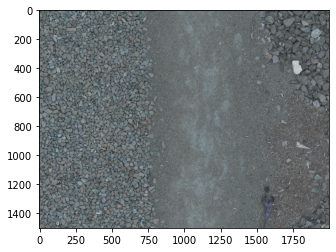

In [257]:
plt.imshow(subimgList[10])


# PROJECT 3D COORDINATES IN IMAGES

visualize 3D point

In [ ]:
centers=np.array([gmu.get_translation(n.cartesianTransform) for n in imgNodes])
points=np.vstack((lambertCoordinates[:,0:3],centers))

#create lines
lines=[]
start=np.arange(start=1,stop=points.shape[0] )[..., np.newaxis]
end=np.zeros((points.shape[0]-1,1 ))
lines = np.hstack((start, end))

#create lineset
line_set = o3d.geometry.LineSet()
line_set.points = o3d.utility.Vector3dVector(points)
line_set.lines = o3d.utility.Vector2iVector(lines)

o3d.visualization.draw_geometries([line_set]+[joinedImages]+[meshNode.resource])

In [9]:
a = lineset[0]
print(a)
p1list = list(lineset[0][0])
p1list.append(1)
p1 = np.array([p1list])
p2list = list(lineset[0][1])
p2list.append(1)
p2 = np.array([p2list])
print(p1)
print(p2)


(Vec3(263379.079273591, 151067.0711606925, 256.3280615631005), Vec3(263378.6810650055, 151067.033252319, 256.3241), 256, 'LIEDGE', -1)
[[2.63379079e+05 1.51067071e+05 2.56328062e+02 1.00000000e+00]]
[[2.63378681e+05 1.51067033e+05 2.56324100e+02 1.00000000e+00]]


convert lambertCoordinates to uvCoordinates for the images

In [52]:
#lambert to imagecoordinates
uvCoordinates1=[]
for n in imgNodes:

    # transform world coordinates to imageCoordinates
    imageCoordinates= np.linalg.inv(n.cartesianTransform) @ p1.T
    # print(imageCoordinates)

    #transform imageCoordinates to xy coordinates on the imageframe
    xy=copy.deepcopy(imageCoordinates)
    xy[0]= imageCoordinates[0]/imageCoordinates[2]*n.focalLength35mm
    xy[1]= imageCoordinates[1]/imageCoordinates[2]*n.focalLength35mm
    xy[2]= imageCoordinates[2]/imageCoordinates[2]*n.focalLength35mm
    # print(xy)

    #transform uv coordinates to uv (row, column) array coordinates
    uv=copy.deepcopy(xy)
    uv[1]=xy[1]+n.imageHeight/2
    uv[0]=xy[0]+n.imageWidth/2
    uv=uv[0:2]
    uvCoordinates1.append(uv)
    n.uvCoordinates1 = uv

uvCoordinates2=[]
for n in imgNodes:

    # transform world coordinates to imageCoordinates
    imageCoordinates= np.linalg.inv(n.cartesianTransform) @ p2.T
    # print(imageCoordinates)

    #transform imageCoordinates to xy coordinates on the imageframe
    xy=copy.deepcopy(imageCoordinates)
    xy[0]= imageCoordinates[0]/imageCoordinates[2]*n.focalLength35mm
    xy[1]= imageCoordinates[1]/imageCoordinates[2]*n.focalLength35mm
    xy[2]= imageCoordinates[2]/imageCoordinates[2]*n.focalLength35mm
    # print(xy)

    #transform uv coordinates to uv (row, column) array coordinates
    uv=copy.deepcopy(xy)
    uv[1]=xy[1]+n.imageHeight/2
    uv[0]=xy[0]+n.imageWidth/2
    uv=uv[0:2]
    uvCoordinates2.append(uv)
    n.uvCoordinates2 = uv
print(uvCoordinates1,uvCoordinates2)
# print(len(uvCoordinates))

[array([[-908.86369133],
       [1498.46182794]]), array([[ -887.84938775],
       [-5597.88992092]]), array([[17141.47842736],
       [23146.01160789]]), array([[ -860.12855492],
       [-3728.23062615]]), array([[ -963.548654  ],
       [-7204.32218996]]), array([[ 7665.78288617],
       [25282.43304299]]), array([[ -839.96563874],
       [10101.19692976]]), array([[ -1026.06616833],
       [-12304.5961498 ]]), array([[  8263.08003823],
       [-17511.89672994]]), array([[17173.78782969],
       [26567.23816594]]), array([[  8308.08152785],
       [-12388.35148745]]), array([[ -1027.76470413],
       [-10564.9687839 ]]), array([[17172.05560422],
       [19686.36592794]]), array([[ -1059.156656  ],
       [-15700.46931945]]), array([[ 7702.47957634],
       [-1001.32856767]]), array([[ 7658.86872815],
       [23383.45804923]]), array([[17220.03555928],
       [ 7249.69586549]]), array([[ 7631.13441796],
       [21744.33158431]]), array([[8448.15681478],
       [4903.82745174]]), array

(8381, 3075)
(8363, 2736)
(8363, 2736)
(8314, 1886)
(8314, 1886)
(8280, 1292)
(8382, 3075)
(8365, 2734)
(8365, 2734)
(8316, 1884)
(8316, 1884)
(8282, 1290)
(8320, 3079)
(8299, 2739)
(8299, 2739)
(8252, 1889)
(8252, 1889)
(8220, 1294)
(8321, 3078)
(8300, 2738)
(8300, 2738)
(8253, 1888)
(8253, 1888)
(8221, 1293)
(8351, 3076)
(8332, 2736)
(8332, 2736)
(8285, 1886)
(8285, 1886)
(8251, 1291)
(9606, 3005)
(9586, 2665)
(9586, 2665)
(9533, 1817)
(9533, 1817)
(9496, 1224)
(9608, 3005)
(9587, 2664)
(9587, 2664)
(9536, 1815)
(9536, 1815)
(9500, 1221)
(9667, 3001)
(9649, 2661)
(9649, 2661)
(9597, 1812)
(9597, 1812)
(9562, 1218)
(9668, 3001)
(9650, 2661)
(9650, 2661)
(9598, 1811)
(9598, 1811)
(9562, 1217)
(9637, 3003)
(9619, 2663)
(9619, 2663)
(9567, 1813)
(9567, 1813)
(9531, 1219)


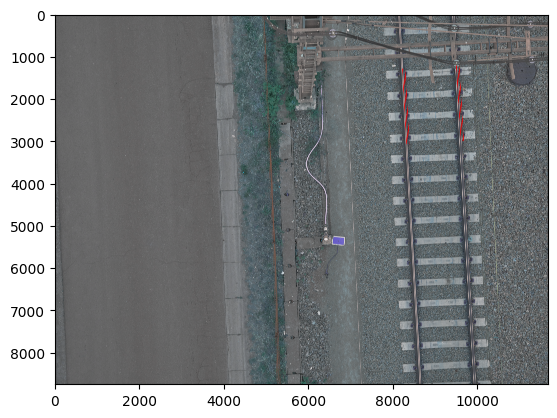

In [54]:
uvCoordinates=[]
im1=next(n for n in imgNodes if n.name =='P0024625') 

def get_uv_coordinates(p):
    for n in imgNodes:

    # transform world coordinates to imageCoordinates
        imageCoordinates= np.linalg.inv(n.cartesianTransform) @ p.T
    # print(imageCoordinates)

    #transform imageCoordinates to xy coordinates on the imageframe
        xy=copy.deepcopy(imageCoordinates)
        xy[0]= imageCoordinates[0]/imageCoordinates[2]*n.focalLength35mm
        xy[1]= imageCoordinates[1]/imageCoordinates[2]*n.focalLength35mm
        xy[2]= imageCoordinates[2]/imageCoordinates[2]*n.focalLength35mm
    # print(xy)

    #transform uv coordinates to uv (row, column) array coordinates
        uv=copy.deepcopy(xy)
        uv[1]=xy[1]+n.imageHeight/2
        uv[0]=xy[0]+n.imageWidth/2
        uv=uv[0:2]
        uvCoordinates.append(uv)
        n.uvCoordinates = uv
    # Return the uv coordinate
    return uv

p1_list = []
p2_list = []

for i in range(0,len(lineset)):
    p1list = list(lineset[i][0])
    p1list.append(1)
    p1 = np.array([p1list])
    p2list = list(lineset[i][1])
    p2list.append(1)
    p2 = np.array([p2list])

    p1_list.append(p1)
    p2_list.append(p2)
    # print(p1list)

image = copy.deepcopy(im1.resource)
for p1, p2 in zip(p1_list, p2_list):
    # Get the uv coordinates for p1 and p2 using the get_uv_coordinates function
    uvCoordinates1 = get_uv_coordinates(p1)
    start = (int(im1.uvCoordinates[0][0]),int(im1.uvCoordinates[1][0]))
    uvCoordinates2 = get_uv_coordinates(p2)
    end = (int(im1.uvCoordinates[0][0]),int(im1.uvCoordinates[1][0]))
    print(start)
    print(end)
    cv2.line(image, start, end, (255,0,0), 5)
    
    # # Append the uvCoordinates1 and uvCoordinates2 arrays to the corresponding lists
    # uvCoordinates1_list.append(uvCoordinates1)
    # uvCoordinates2_list.append(uvCoordinates2)
plt.imshow(image)
plt.show()

visualize the point in the imagery

In [32]:
for n in imgNodes[1:3]:
    print(n.get_resource())

[[[ 98 106 106]
  [ 95 104 107]
  [ 99 108 112]
  ...
  [ 92  97 100]
  [ 92  96 101]
  [ 97 101 106]]

 [[ 96 105 108]
  [ 98 105 108]
  [ 95 104 108]
  ...
  [ 93  98 101]
  [ 93  98 101]
  [ 92  97 100]]

 [[ 94 103 106]
  [102 110 110]
  [ 97 104 107]
  ...
  [ 95 100 101]
  [ 91  96  97]
  [ 91  96  99]]

 ...

 [[129 134 137]
  [121 126 129]
  [124 129 132]
  ...
  [ 97  99 100]
  [ 97  96  98]
  [ 91  90  92]]

 [[122 127 130]
  [121 126 129]
  [124 127 131]
  ...
  [ 96  98  99]
  [ 92  94  95]
  [ 87  91  92]]

 [[127 132 135]
  [126 131 134]
  [125 128 132]
  ...
  [ 93  95  96]
  [ 93  95  96]
  [ 90  94  95]]]
[[[74 82 89]
  [74 81 90]
  [77 84 93]
  ...
  [84 87 91]
  [82 87 88]
  [85 89 90]]

 [[75 83 90]
  [75 83 90]
  [74 84 91]
  ...
  [84 88 89]
  [82 87 88]
  [82 86 87]]

 [[71 81 88]
  [78 86 93]
  [72 83 87]
  ...
  [82 86 87]
  [82 87 88]
  [83 87 88]]

 ...

 [[70 72 82]
  [72 77 86]
  [59 63 68]
  ...
  [88 93 96]
  [87 90 94]
  [88 91 95]]

 [[66 69 77]
  [65 6

(8381, 3075)
(8363, 2736)


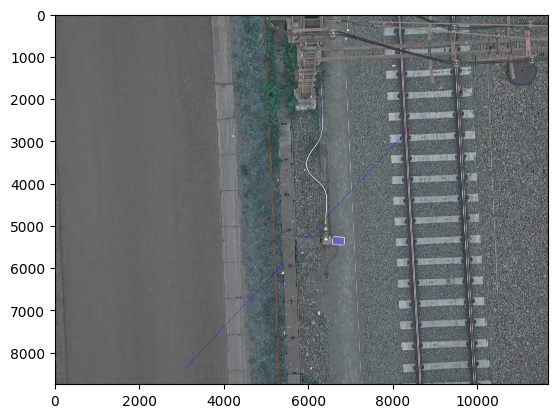

In [55]:
im1=next(n for n in imgNodes if n.name =='P0024625')
im2=next(n for n in imgNodes if n.name =='P0024691')

image = copy.deepcopy(im1.resource)

start = (int(im1.uvCoordinates1[0][0]),int(im1.uvCoordinates1[1][0]))
end = (int(im1.uvCoordinates2[0][0]),int(im1.uvCoordinates2[1][0]))

print(start)
print(end)
cv2.line(image, start, end, (255,0,0), 3)
plt.imshow(image)
plt.show()

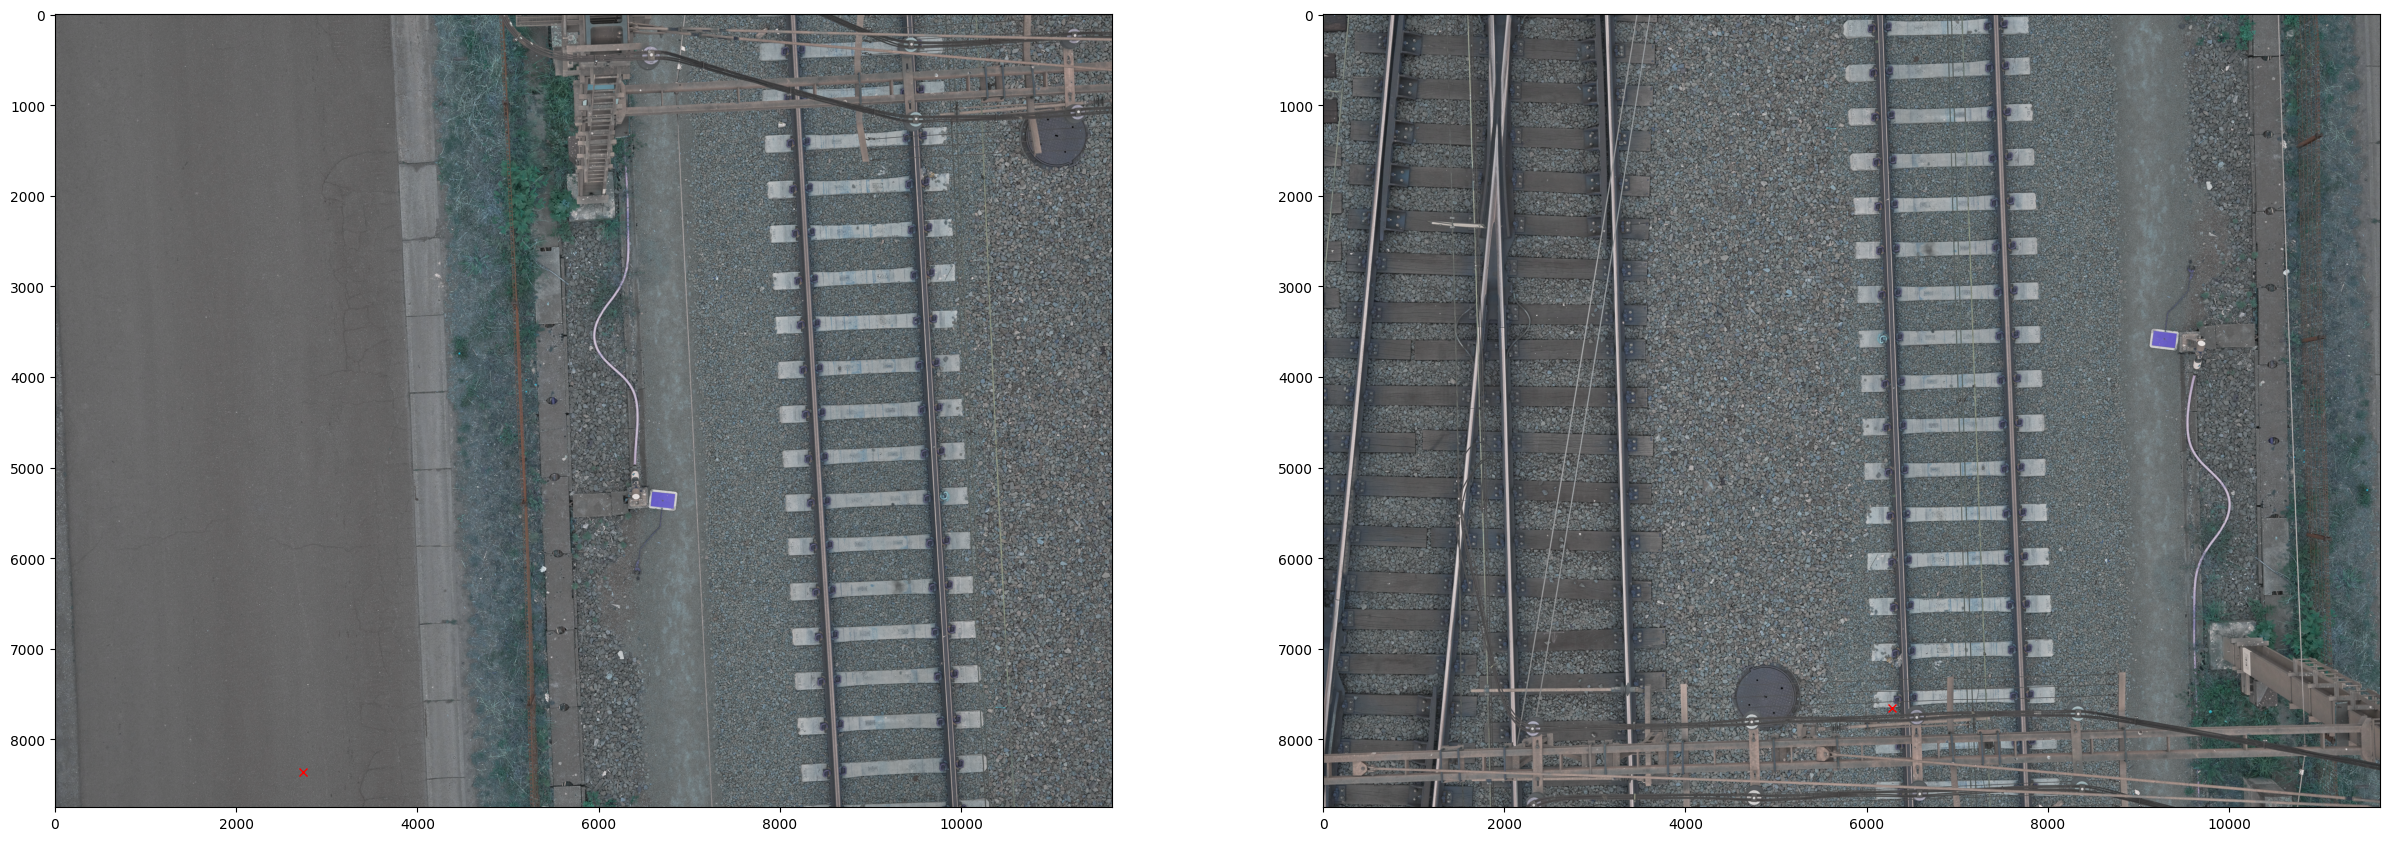

In [39]:
im1=next(n for n in imgNodes if n.name =='P0024625')
im2=next(n for n in imgNodes if n.name =='P0024691')

fig, axs = plt.subplots(1, 2,figsize=(30, 30))

axs[0].imshow(im1.resource)
axs[0].plot(im1.uvCoordinates[0],im1.uvCoordinates[1], color='red', marker='x',)

axs[1].imshow(im2.resource)
axs[1].plot(im2.uvCoordinates[0],im2.uvCoordinates[1], color='red', marker='x',)
# axs[1].imshow(imgNodes[im2].resource)
# axs[1].plot(uvCoordinates[im2][1],uvCoordinates[im2][0], color='red', marker='o',)
plt.savefig('D:/studenten/LouisD/DR NIEUW/Output/PointOnImage.jpg')
plt.show()


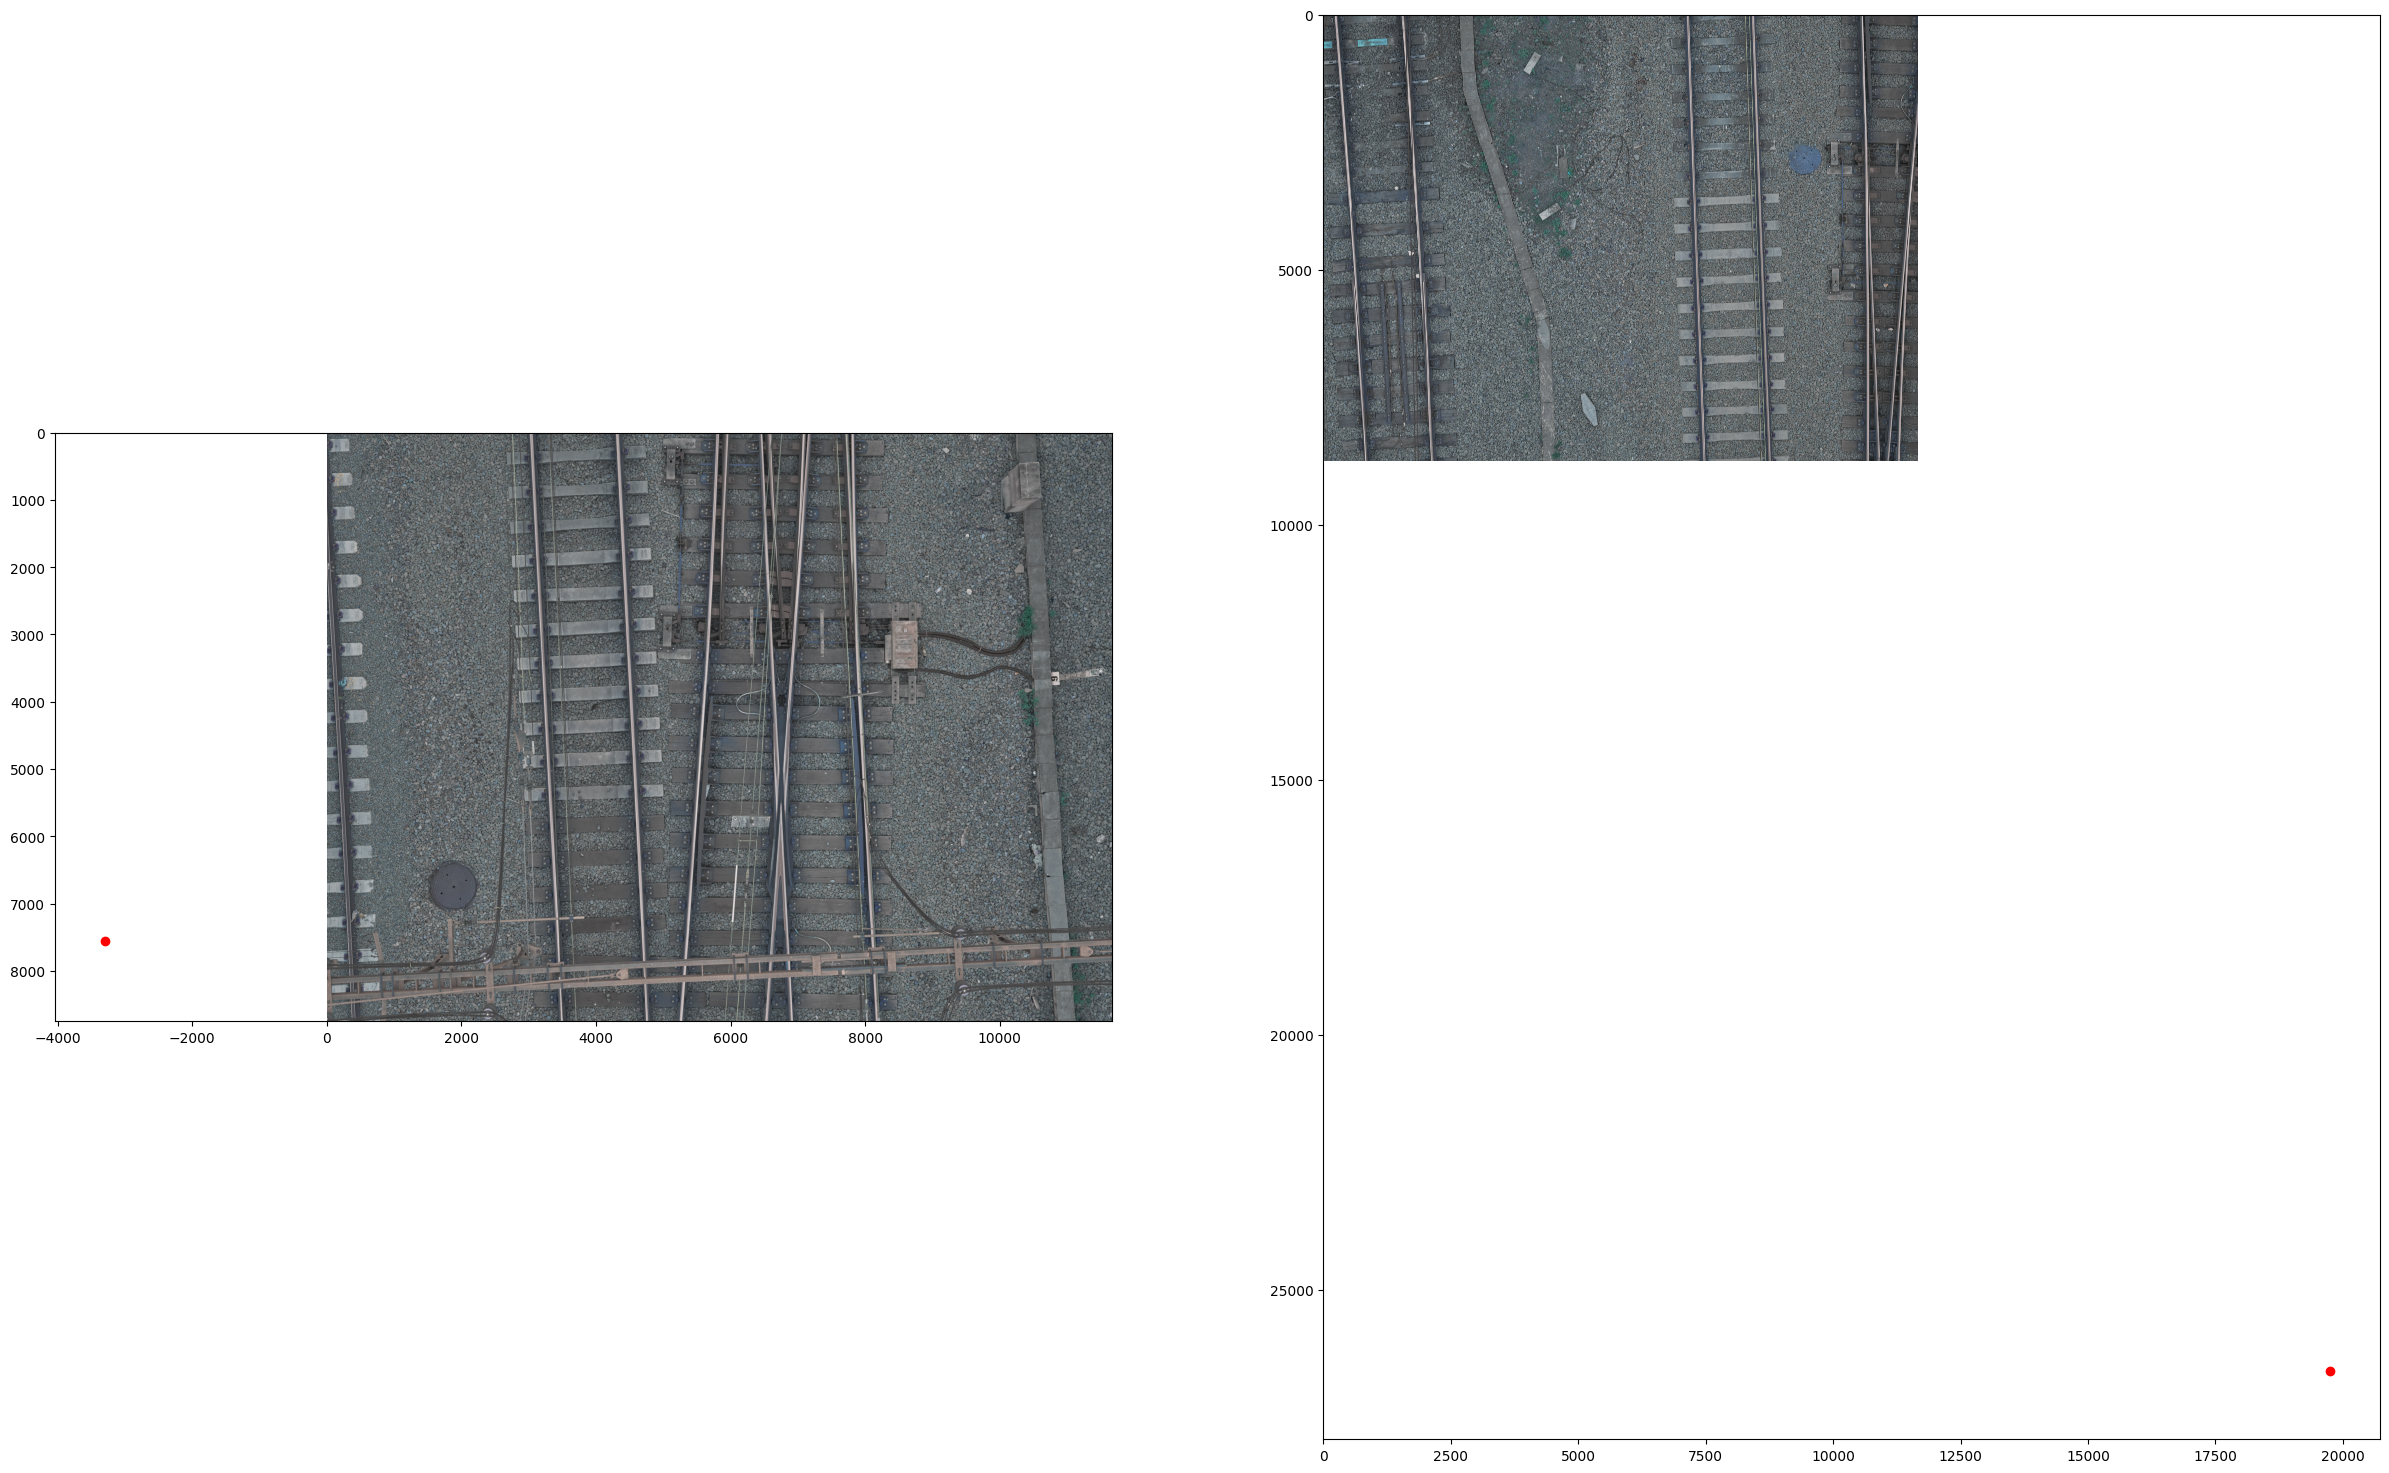

In [18]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2,figsize=(30, 30))

im1=1
im2=2

axs[0].imshow(imgNodes[im1].resource)
axs[0].plot(uvCoordinates[im1][1],uvCoordinates[im1][0], color='red', marker='o',)

axs[1].imshow(imgNodes[im2].resource)
axs[1].plot(uvCoordinates[im2][1],uvCoordinates[im2][0], color='red', marker='o',)
plt.show()

# PROJECT IMAGEPOINTS IN 3D

Get uvCoordinates

In [15]:
uvCoordinates=np.array(copy.deepcopy(uvCoordinates))
uvCoordinates=np.reshape(np.array(uvCoordinates),(len(imgNodes),2))
print(uvCoordinates)

[[ 7361.88535458  6310.70007222]
 [ 1979.50866435  6169.36916335]
 [ 1634.03263573 10003.62678807]
 [ 7069.38248683  9948.14270801]
 [  319.35795697  6107.16389226]
 [ 3482.64219548  9998.85987181]]


transform UV coordinates to world coordinates to rays

In [16]:
rays=np.zeros((1,6))
for n,points in zip(imgNodes,uvCoordinates):
    points=np.array([points])
    rays=np.vstack((rays,n.create_rays(points)))
rays=np.delete(rays,0,axis=0) 
print(rays)

[[ 2.63374763e+05  1.51063706e+05  2.81277422e+02  1.30916999e-01
   2.87608513e-02 -9.90976061e-01]
 [ 2.63380928e+05  1.51064103e+05  2.81282871e+02 -1.20131052e-01
   1.26271618e-02 -9.92677735e-01]
 [ 2.63374334e+05  1.51068993e+05  2.81294884e+02  1.45476750e-01
  -1.82740452e-01 -9.72338646e-01]
 [ 2.63380529e+05  1.51069322e+05  2.81309533e+02 -1.01939962e-01
  -1.96303391e-01 -9.75229831e-01]
 [ 2.63382830e+05  1.51064246e+05  2.81283450e+02 -1.95275252e-01
   6.71722984e-03 -9.80725474e-01]
 [ 2.63376474e+05  1.51069102e+05  2.81302900e+02  6.05658067e-02
  -1.88520879e-01 -9.80199807e-01]]


(optional) cast rays for custom set of rays such as the image size

In [14]:
# start an array of rays () -> tensor
rays=np.zeros((1,6))
for n in imgNodes:
    # example uv points (top left, middle and bottom right)
    uvCoordinates=np.array([[0,0], # top left
                            [0,n.imageWidth], # top right
                            [np.floor(n.imageHeight/2),np.floor(n.imageWidth/2)], #middle
                            [n.imageHeight,0], # bottom left
                            [n.imageHeight,n.imageWidth] # bottom right
                            ])
    # transform uvcoordinates  to world coordinates to rays   
    rays=np.vstack((rays,n.create_rays(uvCoordinates)))

    # cast rays to 3D mesh -> this is slow if you do it for every node
    # distances,_=gmu.compute_raycasting_collisions(pcdNode.resource,rays)
    # # #compute endpoints 
    # _,endpoints=gmu.rays_to_points(rays,distances)
    # print(rays)
    # print(uvCoordinates)
rays=np.delete(rays,0,axis=0) 

visualize rays

In [15]:
# array=np.vstack([n.ray for n in damageCandidateNodes])
# darray=np.vstack([np.reshape(n.distances,(distances.shape[0],1)) for n in damageCandidateNodes])
line_set=gmu.rays_to_lineset(rays,50)
# # line_set.colors=o3d.utility.Vector3dVector(np.vstack((np.array([1,0,0]),np.array([0,1,0]),np.array([0,0,1]),np.zeros((len(line_set.lines)-3,3)))))
o3d.visualization.draw_geometries([line_set]+[joinedImages]+[meshNode.resource])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: De ingang is ongeldig. 


# CREATE RDF GRAPH OF IMAGES

An RDF graph and .ttl file is created for all nodes 
(data itself is not stored in the graph, only metadata)

In [173]:
imgGraph=tl.nodes_to_graph(imgNodes,imgGraphPath,save=True)
print (f'{len(imgNodes)} Nodes succesfully serialized in: {imgGraphPath}')

6 Nodes succesfully serialized in: D:/Data/TUCRAIL/cameras_L72_0312.ttl


# PARSE IMAGEGRAPH

In [174]:
nodeList=tl.graph_path_to_nodes(imgGraphPath)
print(len(nodeList))

6


c:\Users\u0094523\.conda\envs\conda_environment3\lib\site-packages\PIL\Image.py:3074: DecompressionBombWarning: Image size (102060000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [175]:
{key:value for key, value in nodeList[0].__dict__.items() if not key.startswith('__') and not callable(key)}              

{'_xmlPath': None,
 '_xmpPath': None,
 '_orientedBoundingBox': None,
 'imageWidth': 11664,
 'imageHeight': 8750,
 'focalLength35mm': 21276.5957031249,
 'keypoints': None,
 'descriptors': None,
 '_subject': rdflib.term.URIRef('file:///06332674-d1f2-11ed-8fc0-c8f75043ce59'),
 '_graph': <Graph identifier=N03cad3e1468c4e78914f6300bce7b49c (<class 'rdflib.graph.Graph'>)>,
 '_graphPath': 'D:/Data/TUCRAIL/cameras_L72_0312.ttl',
 '_path': 'D:/Data/TUCRAIL\\P0024624.jpg',
 '_name': 'P0024624',
 '_timestamp': '2023-04-03T09:33:08',
 '_resource': None,
 '_cartesianTransform': array([[-8.35427289e-02,  1.91778056e+00, -1.50033543e-02,
          2.63382830e+05],
        [ 1.91783298e+00,  8.35783123e-02,  4.25654402e-03,
          1.51064246e+05],
        [ 4.90559907e-03, -1.48038476e-02, -1.91959464e+00,
          2.81283450e+02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 'type': 'https://w3id.org/v4d/core#ImageNode',
 'intrinsic_matrix': '[[2.12765